<a href="https://colab.research.google.com/github/veiro/tesis-imputacion-datos/blob/main/codigo/dataprofile/Dataprofile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install ydata-profiling &> /dev/null

In [ ]:
from ydata_profiling import ProfileReport

#Objetivo del notebook:
Integrar datos, curarlos y dividirlos en subsets para proximas tareas de analsis de prediccion.

#Datos:
proporcionados por la universidad de johns Hopkins, https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data

In [ ]:
# Bibliotecas a utilizar
import os
import sys

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import pandas
from sklearn.model_selection import train_test_split
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import time
from tqdm import tqdm
from google.colab import drive
import pickle

In [ ]:
# variables globales
USAR_GOOGLE_DRIVE = True

In [ ]:
if (USAR_GOOGLE_DRIVE):
  drive.mount('/content/gdrive')
  PATH_DATA_PROCESADA = "/content/gdrive/MyDrive/Maestria/Tesis/Codigo/data/data-procesada"
  sys.path.append('/content/gdrive/MyDrive/Maestria/Tesis/Codigo/utils')
  import utils as utils


Mounted at /content/gdrive


In [ ]:
!python3 -m pip freeze

absl-py==1.4.0
aiohttp==3.9.1
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
altair==4.2.2
annotated-types==0.6.0
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.11.2
bidict==0.22.1
bigframes==0.19.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.3
bqplot==0.12.42
branca==0.7.0
build==1.0.3
CacheControl==0.13.1
cachetools==5.3.2
catalogue==2.0.10
certifi==2023.11.17
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.7
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.0
colorcet==3.0.1
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.0
cryptography==41.0.7
cufflinks==0.17.3
cupy-cuda12x==12.2.0
cvxopt==1.3.2
cvxpy=

# Funciones auxiliares



In [ ]:
def guardarDatos(data, nombreArchivo):
  if (USAR_GOOGLE_DRIVE):
    data.to_csv(PATH_DATA_PROCESADA+'/'+nombreArchivo, index=False)

def armarRangoFechas(startDate, endDate):# start date
  formato_fecha="%m-%d-%Y"
  start_date = datetime.strptime(startDate, formato_fecha)
  end_date = datetime.strptime(endDate, formato_fecha)

  # difference between each date. D means one day
  D = 'D'

  date_list = pandas.date_range(start_date, end_date, freq=D)
  print(f"Creating list of dates starting from {start_date} to {end_date}")
  #print(date_list)

  # if you want dates in string format then convert it into string
  return date_list.strftime(formato_fecha)
  #print(rangos_fecha)

In [ ]:
def obtenerDatos(startDate, endDate, url):
  rangos_fecha = armarRangoFechas(startDate, endDate)
  filepath = url + '01-01-2021.csv'
  data = pandas.read_csv(filepath)
  data['date'] = '01-01-2021'
  filepath=""

  total_iterations = rangos_fecha

  for date in tqdm(rangos_fecha):
    try:
      filepath = url + date + '.csv'
      patial_data = pandas.read_csv(filepath)
      patial_data['date'] = date
      data = pandas.concat([data, patial_data])
    except:
      print("\n"+"Error al obtener: " + filepath + "\n")

  return data


# Datos globales de covid

In [ ]:
url = 'https://raw.githubusercontent.com/veiro/master-tesis-data-imputation/master/data/sin-procesar/csse_covid_19_daily_reports/'
datos = obtenerDatos("01-01-2021", "03-09-2023", url)

Creating list of dates starting from 2021-01-01 00:00:00 to 2023-03-09 00:00:00


100%|██████████| 798/798 [06:00<00:00,  2.21it/s]


In [ ]:
utils.mostrarDatos(datos)

Nombre datos: 

--------------------------------------------------------------------------------

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incident_Rate', 'Case_Fatality_Ratio', 'date'],
      dtype='object')

--------------------------------------------------------------------------------

SHAPE:

(3208207, 15)

--------------------------------------------------------------------------------

Count of NaN:

7243441

--------------------------------------------------------------------------------



In [ ]:
report = ProfileReport(datos, minimal=True)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
guardarDatos(datos, "csse_covid_19_data")

# Preparacion de juego de datos para pruebas y analisis


## Preparo los datos


In [ ]:
%%time

data_sin_columnas_completas = datos.drop(['FIPS', 'Admin2', 'Recovered', 'Active', 'Combined_Key'], axis=1)
data_sin_null = data_sin_columnas_completas.dropna(subset=['Province_State', 'Lat', 'Long_', 'Incident_Rate', 'Case_Fatality_Ratio'])


CPU times: user 999 ms, sys: 493 ms, total: 1.49 s
Wall time: 1.49 s


In [ ]:
data_sin_null.head(5)

Province_State Country_Region          Last_Update      Lat  \
8   Australian Capital Territory      Australia  2021-01-02 05:22:33 -35.4735   
9                New South Wales      Australia  2021-01-02 05:22:33 -33.8688   
10            Northern Territory      Australia  2021-01-02 05:22:33 -12.4634   
11                    Queensland      Australia  2021-01-02 05:22:33 -27.4698   
12               South Australia      Australia  2021-01-02 05:22:33 -34.9285   

       Long_  Confirmed  Deaths  Incident_Rate  Case_Fatality_Ratio  \
8   149.0124        118       3      27.563653             2.542373   
9   151.2093       4947      54      60.938655             1.091571   
10  130.8456         75       0      30.537459             0.000000   
11  153.0251       1255       6      24.533281             0.478088   
12  138.6007        580       4      33.020211             0.689655   

          date  
8   01-01-2021  
9   01-01-2021  
10  01-01-2021  
11  01-01-2021  
12  01-01-2021

In [ ]:
report = ProfileReport(data_sin_null, minimal=True)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Funciones para armar datasets

In [ ]:


def missing_method(raw_data) :

    data = raw_data.copy()
    rows, cols = data.shape

    # missingness threshold
    t = 0.2

    # uniform random vector
    v = np.random.uniform(0., 1.,size=(rows, cols))

    # missing values where v<=t
    mask = (v<=t)
    data[mask] = np.nan

    return data, mask


In [ ]:

def armarJuegoDatos(data_sin_null, modo):
  test_size = 0.3

  data_sin_null_encoded = utils.encoding(data_sin_null, PATH_DATA_PROCESADA)


  train_data_encoded, test_data_encoded = train_test_split(data_sin_null_encoded, test_size=test_size, random_state=42)

  # guardo train y test codificados sin missing. Estos datos son para la pruebas de prediccion.
  train_data_encoded.to_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_train_encoded=True_missing=False_' + modo + '.csv', index=False)
  test_data_encoded.to_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_test_encoded=True_missing=False_' + modo + '.csv', index=False)

  # esto es para para las pruebas de prediccion
  train_data_decoded = utils.decode(train_data_encoded, data_sin_null_encoded, PATH_DATA_PROCESADA)

  test_data_decoded = utils.decode(test_data_encoded, data_sin_null_encoded, PATH_DATA_PROCESADA)


  train_data_decoded.to_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_train_decode=True_missing=False_' + modo + '.csv', index=False)
  test_data_decoded.to_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_test_decode=True_missing=False_' + modo + '.csv', index=False)


  ## llamar al missing method y guardar datos con miss, mask codificados. Estos son para entrenar los modelos de imputacion // no me queda claro si test_data_encoded_missing se usaria.
  train_data_encoded_missing, train_data_mask = missing_method(train_data_encoded)
  test_data_encoded_missing, test_data_mask = missing_method(test_data_encoded)


  train_data_encoded_missing.to_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_train_encoded=True_missing=True_' + modo + '.csv', index=False)
  np.save(PATH_DATA_PROCESADA + '/csse_covid_19_data_train_mask_'+ modo , train_data_mask)

  test_data_encoded_missing.to_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_test_encoded=True_missing=True_' + modo + '.csv', index=False)
  np.save(PATH_DATA_PROCESADA + '/csse_covid_19_data_test_mask_'+ modo , test_data_mask)


  ## armo los datos decodificados, sin missing // esto puede servir para comprar lo imputado con lo real
  train_data_decoded = utils.decode(train_data_encoded, data_sin_null_encoded, PATH_DATA_PROCESADA)
  test_data_decoded = utils.decode(test_data_encoded, data_sin_null_encoded, PATH_DATA_PROCESADA)


  train_data_decoded.to_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_train_decode=False_missing=False_' + modo + '.csv', index=False)
  test_data_decoded.to_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_test_decode=False_missing=False_' + modo + '.csv', index=False)


  ## armo los datos decodificados, con missing /// no creo que se usen por que no tiene sentido ver que valores se borraron.

'''
  train_data_decoded_missing = decode(train_data_encoded_missing, data_sin_null_encoded)
  test_data_decoded_missing = decode(test_data_encoded_missing, data_sin_null_encoded)

  train_data_decoded_missing.to_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_train_decode=False_missing=True_' + modo + '.csv', index=False)
  test_data_decoded_missing.to_csv(PATH_DATA_PRCESADA + '/csse_covid_19_data_test_decode=False_missing=True_' + modo + '.csv', index=False)
  '''


"\n  train_data_decoded_missing = decode(train_data_encoded_missing, data_sin_null_encoded)\n  test_data_decoded_missing = decode(test_data_encoded_missing, data_sin_null_encoded)\n\n  train_data_decoded_missing.to_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_train_decode=False_missing=True_' + modo + '.csv', index=False)\n  test_data_decoded_missing.to_csv(PATH_DATA_PRCESADA + '/csse_covid_19_data_test_decode=False_missing=True_' + modo + '.csv', index=False)\n  "

In [ ]:
import importlib
importlib.reload(utils)

<module 'utils' from '/content/gdrive/MyDrive/Maestria/Tesis/Codigo/utils/utils.py'>

## Invocaciones

In [ ]:
%%time
armarJuegoDatos(data_sin_null, 'Desarrollo=False')

##armo los datos de desarrollo
#data_utilizar = data_sin_null.sample(n=10000, random_state=1)
#armarJuegoDatos(data_utilizar, 'Desarrollo=True')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False)


2094556it [04:50, 7198.66it/s]


OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False)


897667it [02:04, 7233.75it/s]


OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False)


2094556it [04:49, 7230.64it/s]


OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False)


897667it [02:03, 7272.23it/s]


CPU times: user 16min 35s, sys: 12.7 s, total: 16min 48s
Wall time: 17min 26s


#  Analisis juegos de datos

In [ ]:
%%time
train_data_encoded_open = pandas.read_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_train_encoded=True_missing=False_' + 'Desarrollo=False' + '.csv')
test_data_encoded_open =  pandas.read_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_test_encoded=True_missing=False_' + 'Desarrollo=False'  + '.csv')

train_data_decoded_open = pandas.read_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_train_decode=True_missing=False_' + 'Desarrollo=False' + '.csv')
test_data_decoded_open = pandas.read_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_test_decode=True_missing=False_' + 'Desarrollo=False' + '.csv')

train_data_encoded_missing_open = pandas.read_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_train_encoded=True_missing=True_' + 'Desarrollo=False'  + '.csv')
mask_train_open = np.load(PATH_DATA_PROCESADA + '/csse_covid_19_data_train_mask_'+ 'Desarrollo=False'+ '.npy')

test_data_encoded_missing_open = pandas.read_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_test_encoded=True_missing=True_' + 'Desarrollo=False' + '.csv')
mask_test_open = np.load(PATH_DATA_PROCESADA + '/csse_covid_19_data_test_mask_'+ 'Desarrollo=False'+ '.npy')

train_data_decoded_open = pandas.read_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_train_decode=False_missing=False_' + 'Desarrollo=False' + '.csv')
test_data_decoded_open = pandas.read_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_test_decode=False_missing=False_' + 'Desarrollo=False' + '.csv')

#train_data_decoded_missing_open = pandas.read_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_train_decode=False_missing=True_' + 'Desarrollo=False' + '.csv')
#test_data_decoded_missing_open = pandas.read_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_test_decode=False_missing=True_' + 'Desarrollo=False' + '.csv')

CPU times: user 23.5 s, sys: 3.04 s, total: 26.6 s
Wall time: 28.3 s


### train_data_encoded_open

In [ ]:
#report = ProfileReport(train_data_encoded_open, minimal=True)
#report

In [ ]:
utils.mostrarDatos(train_data_encoded_open)

Nombre datos: 

--------------------------------------------------------------------------------

Index(['Country_Region_Australia', 'Country_Region_Belgium',
       'Country_Region_Brazil', 'Country_Region_Canada',
       'Country_Region_Chile', 'Country_Region_China',
       'Country_Region_Colombia', 'Country_Region_Denmark',
       'Country_Region_France', 'Country_Region_Germany',
       'Country_Region_India', 'Country_Region_Italy', 'Country_Region_Japan',
       'Country_Region_Malaysia', 'Country_Region_Mexico',
       'Country_Region_Netherlands', 'Country_Region_New Zealand',
       'Country_Region_Pakistan', 'Country_Region_Peru',
       'Country_Region_Russia', 'Country_Region_Spain',
       'Country_Region_Sweden', 'Country_Region_US', 'Country_Region_Ukraine',
       'Country_Region_United Kingdom', 'Lat', 'Long_', 'Confirmed', 'Deaths',
       'Incident_Rate', 'Case_Fatality_Ratio', 'Province_State_encoded',
       'Last_Update_encoded', 'date_encoded'],
      dtype='ob

### test_data_encoded_open

In [ ]:
#report = ProfileReport(test_data_encoded_open, minimal=True)
#report

In [ ]:
utils.mostrarDatos(test_data_encoded_open)

Nombre datos: 

--------------------------------------------------------------------------------

Index(['Country_Region_Australia', 'Country_Region_Belgium',
       'Country_Region_Brazil', 'Country_Region_Canada',
       'Country_Region_Chile', 'Country_Region_China',
       'Country_Region_Colombia', 'Country_Region_Denmark',
       'Country_Region_France', 'Country_Region_Germany',
       'Country_Region_India', 'Country_Region_Italy', 'Country_Region_Japan',
       'Country_Region_Malaysia', 'Country_Region_Mexico',
       'Country_Region_Netherlands', 'Country_Region_New Zealand',
       'Country_Region_Pakistan', 'Country_Region_Peru',
       'Country_Region_Russia', 'Country_Region_Spain',
       'Country_Region_Sweden', 'Country_Region_US', 'Country_Region_Ukraine',
       'Country_Region_United Kingdom', 'Lat', 'Long_', 'Confirmed', 'Deaths',
       'Incident_Rate', 'Case_Fatality_Ratio', 'Province_State_encoded',
       'Last_Update_encoded', 'date_encoded'],
      dtype='ob

### train_data_decoded_open

In [ ]:
utils.mostrarDatos(train_data_decoded_open)

Nombre datos: 

--------------------------------------------------------------------------------

Index(['Province_State', 'Country_Region', 'Last_Update', 'Lat', 'Long_',
       'Confirmed', 'Deaths', 'Incident_Rate', 'Case_Fatality_Ratio', 'date'],
      dtype='object')

--------------------------------------------------------------------------------

SHAPE:

(2094556, 10)

--------------------------------------------------------------------------------

Count of NaN:

0

--------------------------------------------------------------------------------



### test_data_decoded_open

In [ ]:
utils.mostrarDatos(test_data_decoded_open)

Nombre datos: 

--------------------------------------------------------------------------------

Index(['Province_State', 'Country_Region', 'Last_Update', 'Lat', 'Long_',
       'Confirmed', 'Deaths', 'Incident_Rate', 'Case_Fatality_Ratio', 'date'],
      dtype='object')

--------------------------------------------------------------------------------

SHAPE:

(897667, 10)

--------------------------------------------------------------------------------

Count of NaN:

0

--------------------------------------------------------------------------------



### train_data_encoded_missing_open


In [ ]:
#report = ProfileReport(train_data_encoded_missing_open, minimal=True)
#report

In [ ]:
utils.mostrarDatos(train_data_encoded_missing_open)

Nombre datos: 

--------------------------------------------------------------------------------

Index(['Country_Region_Australia', 'Country_Region_Belgium',
       'Country_Region_Brazil', 'Country_Region_Canada',
       'Country_Region_Chile', 'Country_Region_China',
       'Country_Region_Colombia', 'Country_Region_Denmark',
       'Country_Region_France', 'Country_Region_Germany',
       'Country_Region_India', 'Country_Region_Italy', 'Country_Region_Japan',
       'Country_Region_Malaysia', 'Country_Region_Mexico',
       'Country_Region_Netherlands', 'Country_Region_New Zealand',
       'Country_Region_Pakistan', 'Country_Region_Peru',
       'Country_Region_Russia', 'Country_Region_Spain',
       'Country_Region_Sweden', 'Country_Region_US', 'Country_Region_Ukraine',
       'Country_Region_United Kingdom', 'Lat', 'Long_', 'Confirmed', 'Deaths',
       'Incident_Rate', 'Case_Fatality_Ratio', 'Province_State_encoded',
       'Last_Update_encoded', 'date_encoded'],
      dtype='ob

### mask_train_open

In [ ]:
# prompt: mostrar informacion relevante de  mask_train_open

print(mask_train_open.shape)
print(mask_train_open.dtype)
print(mask_train_open.sum())


(2094556, 34)
bool
14240815


### test_data_encoded_missing_open

In [ ]:
#report = ProfileReport(test_data_encoded_missing_open, minimal=True)
#repor

In [ ]:
utils.mostrarDatos(test_data_encoded_missing_open)

Nombre datos: 

--------------------------------------------------------------------------------

Index(['Country_Region_Australia', 'Country_Region_Belgium',
       'Country_Region_Brazil', 'Country_Region_Canada',
       'Country_Region_Chile', 'Country_Region_China',
       'Country_Region_Colombia', 'Country_Region_Denmark',
       'Country_Region_France', 'Country_Region_Germany',
       'Country_Region_India', 'Country_Region_Italy', 'Country_Region_Japan',
       'Country_Region_Malaysia', 'Country_Region_Mexico',
       'Country_Region_Netherlands', 'Country_Region_New Zealand',
       'Country_Region_Pakistan', 'Country_Region_Peru',
       'Country_Region_Russia', 'Country_Region_Spain',
       'Country_Region_Sweden', 'Country_Region_US', 'Country_Region_Ukraine',
       'Country_Region_United Kingdom', 'Lat', 'Long_', 'Confirmed', 'Deaths',
       'Incident_Rate', 'Case_Fatality_Ratio', 'Province_State_encoded',
       'Last_Update_encoded', 'date_encoded'],
      dtype='ob

### mask_test_open

In [ ]:
# prompt: mostrar informacion relevante de  mask_train_open

print(mask_test_open.shape)
print(mask_test_open.dtype)
print(mask_test_open.sum())


(897667, 34)
bool
6104624


### train_data_decoded_open (no se puede decodificar por los Nan)

In [ ]:
#report = ProfileReport(train_data_decoded_open, minimal=True)
#report

In [ ]:
#mostrarDatos(train_data_decoded_open)

## test_data_decoded_open  (no se puede decodificar por los Nan)




In [ ]:
#report = ProfileReport(test_data_decoded_open, minimal=True)
#report

In [ ]:
#mostrarDatos(test_data_decoded_open)

# Embbedings


Se baso en https://arxiv.org/pdf/1604.06737.pdf
y yo en  https://colab.research.google.com/drive/13U4YRIdEu7SWS1ttiJPSrSayQHNbIaT_?usp=sharing#scrollTo=qSoepAKnfmvN

In [ ]:
# Data processing
import pandas as pd
import numpy as np

# Train test split
from sklearn.model_selection import train_test_split

# Model
from sklearn.ensemble import RandomForestRegressor

# Visualization
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)}) # Set figure size
import matplotlib.pyplot as plt

# Visualize neural network model structure
from keras.utils import plot_model
from IPython.display import Image

# Deep learning model
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Embedding
from tensorflow.keras.models import Model, load_model
from keras.callbacks import EarlyStopping

In [ ]:
X_train = pandas.read_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_train_decode=False_missing=False_' + 'Desarrollo=False' + '.csv')
X_test = pandas.read_csv(PATH_DATA_PROCESADA + '/csse_covid_19_data_test_decode=False_missing=False_' + 'Desarrollo=False' + '.csv')


## obtengo coidigo para valores de varibles categoricas+

In [ ]:

def encodeCategoricalVariable(columnsCategorial):
  salida = []
  for column in columnsCategorial:
  # Categorical encoder is in dictionary format
    cat_encoder = {}

    # Unique values for the categorical variable
    unique_cat = np.unique(data_sin_null[ column])

    # Print out the number of unique values in the categorical variable
    print(f'There are {len(unique_cat)} unique ' + column + '  in the training dataset.\n')

    # Encode the categorical variable
    for i in range(len(unique_cat)):
      cat_encoder[unique_cat[i]] = i

    print(cat_encoder)
    print("------------------------------------------------------------------------------------------------------------------")
    salida.append(  {'column': column, 'cat_encoder':cat_encoder, 'unique_cat':unique_cat})
  # Take a look at the encoder
  return salida

columanas_categoricas = ['Country_Region','Province_State','date', 'Last_Update']
encoderCategorialVariables=  encodeCategoricalVariable(columanas_categoricas)



There are 25 unique Country_Region  in the training dataset.

{'Australia': 0, 'Belgium': 1, 'Brazil': 2, 'Canada': 3, 'Chile': 4, 'China': 5, 'Colombia': 6, 'Denmark': 7, 'France': 8, 'Germany': 9, 'India': 10, 'Italy': 11, 'Japan': 12, 'Malaysia': 13, 'Mexico': 14, 'Netherlands': 15, 'New Zealand': 16, 'Pakistan': 17, 'Peru': 18, 'Russia': 19, 'Spain': 20, 'Sweden': 21, 'US': 22, 'Ukraine': 23, 'United Kingdom': 24}
------------------------------------------------------------------------------------------------------------------
There are 592 unique Province_State  in the training dataset.

{'Abruzzo': 0, 'Acre': 1, 'Adygea Republic': 2, 'Aguascalientes': 3, 'Aichi': 4, 'Akita': 5, 'Alabama': 6, 'Alagoas': 7, 'Alaska': 8, 'Alberta': 9, 'Altai Krai': 10, 'Altai Republic': 11, 'Amapa': 12, 'Amazonas': 13, 'American Samoa': 14, 'Amur Oblast': 15, 'Ancash': 16, 'Andalusia': 17, 'Andaman and Nicobar Islands': 18, 'Andhra Pradesh': 19, 'Anguilla': 20, 'Anhui': 21, 'Antioquia': 22, 'Antofag

In [ ]:
# Input list for the training data
input_list_train = []

# Input list for the testing data
input_list_test = []

for  element in encoderCategorialVariables:
  input_list_train.append(X_train[element.get('column')].map(element.get('cat_encoder')).values)
  input_list_test.append(X_test[element.get('column')].map(element.get('cat_encoder')).values)


## armo RN

In [ ]:
def addEmmbedingLayer(encoderCategorialVariables, dimension):
  salida = []
  for  element in encoderCategorialVariables:
    column = element.get('column')
    unique_cat = element.get('unique_cat')
    # Input dimension of the categorical variable
    input_cat = Input(shape=(1,), name="input_cat_"+element.get('column'))

    # Embedding layer
    emb_cat = Embedding(input_dim= len(unique_cat) , output_dim=dimension, name="embedding_cat_"+column)(input_cat)
    # Check the output shape
    print(emb_cat)

    # Reshape
    emb_cat = Reshape(target_shape=(dimension, ), name="Reshape_"+column)(emb_cat)
    # Check the output shape
    print(emb_cat)
    salida.append({'column': column, 'emb_cat':emb_cat, 'input_cat': input_cat})
  # Take a look at the encoder
  return salida

EmmbedingLayers= addEmmbedingLayer(encoderCategorialVariables, 3)

KerasTensor(type_spec=TensorSpec(shape=(None, 1, 3), dtype=tf.float32, name=None), name='embedding_cat_Country_Region/embedding_lookup/Identity:0', description="created by layer 'embedding_cat_Country_Region'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='Reshape_Country_Region/Reshape:0', description="created by layer 'Reshape_Country_Region'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 3), dtype=tf.float32, name=None), name='embedding_cat_Province_State/embedding_lookup/Identity:0', description="created by layer 'embedding_cat_Province_State'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='Reshape_Province_State/Reshape:0', description="created by layer 'Reshape_Province_State'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 3), dtype=tf.float32, name=None), name='embedding_cat_date/embedding_lookup/Identity:0', description="created by layer 'embedding_cat_date'")
KerasTensor(type_spec=TensorSpe

In [ ]:
# List of numerical columns
numeric_cols = ['Lat', 'Long_', 'Confirmed', 'Deaths', 'Incident_Rate', 'Case_Fatality_Ratio' ]

# Append numerical values to the training and testing list
input_list_train.append(X_train[numeric_cols].values)
input_list_test.append(X_test[numeric_cols].values)

#n Take a look at the data
print('input_list_train:', input_list_train)
print('input_list_test:', input_list_test)

input_list_train: [array([22, 22, 22, ..., 22, 22, 22]), array([509, 509, 509, ..., 509, 509, 509]), array([0, 0, 0, ..., 0, 0, 0]), array([1, 1, 1, ..., 1, 1, 1]), array([[ 3.58380970e+01, -1.00813200e+02,  1.83000000e+02,
         2.00000000e+00,  2.14285714e+04,  1.09289617e+00],
       [ 4.71153050e+01, -1.01340600e+02,  3.77000000e+02,
         5.00000000e+00,  1.92445125e+04,  1.32625995e+00],
       [ 4.09618880e+01, -7.70600000e+01,  1.17910000e+04,
         1.54000000e+02,  2.62471340e+04,  1.30608091e+00],
       ...,
       [ 2.79276560e+01, -8.23201000e+01,  4.42313000e+05,
         4.00600000e+03,  3.00490907e+04,  9.05693480e-01],
       [ 3.79014480e+01, -1.03717300e+02,  5.24700000e+03,
         1.36000000e+02,  2.87066419e+04,  2.59195731e+00],
       [ 4.72658490e+01, -1.04894400e+02,  2.55000000e+03,
         5.90000000e+01,  2.96064089e+04,  2.31372549e+00]])]
input_list_test: [array([22, 22, 22, ..., 22, 22, 22]), array([509, 509, 509, ..., 509, 509, 509]), array([

In [ ]:
# Input dimension of the numeric variables
input_numeric = Input(shape=(len(numeric_cols),), name="Numeric_cols_input")

# Output dimension of the numeric variables
emb_numeric = input_numeric

# Take a look at the output dimension
emb_numeric

<KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'Numeric_cols_input')>

In [ ]:
# Input data dimensions
input_data = []
emb_data = []
for  element in EmmbedingLayers:
  input_cat = element.get('input_cat')
  input_data.append(input_cat)

  emb_cat = element.get('emb_cat')
  emb_data.append(emb_cat)

# Input data dimensions
input_data.append(input_numeric)
emb_data.append(emb_numeric)

# Take a look at the data
input_data




[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_cat_Country_Region')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_cat_Province_State')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_cat_date')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_cat_Last_Update')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'Numeric_cols_input')>]

In [ ]:
# Concatenate layer concatenates a list of inputs
model_data = Concatenate()(emb_data)
model_data
# Dense layer with 10 neurons and relu activation function
model = Dense(10, activation = 'relu')(model_data)
# Dense layer with 5 neurons and relu activation function
model = Dense(5, activation = 'relu')(model)
# Dense layer with 2 neurons and relu activation function
model = Dense(2, activation = 'relu')(model)
# Output is linear
outputs = Dense(1, activation = 'linear')(model)

# Use Model to group layers into an object with training and inference features
nn = Model(inputs=input_data, outputs=outputs, name ='Entity_embedding_model_keras')

# Print out the model summary
nn.summary()

Model: "Entity_embedding_model_keras"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_cat_Country_Region (  [(None, 1)]                  0         []                            
 InputLayer)                                                                                      
                                                                                                  
 input_cat_Province_State (  [(None, 1)]                  0         []                            
 InputLayer)                                                                                      
                                                                                                  
 input_cat_date (InputLayer  [(None, 1)]                  0         []                            
 )                                                                     

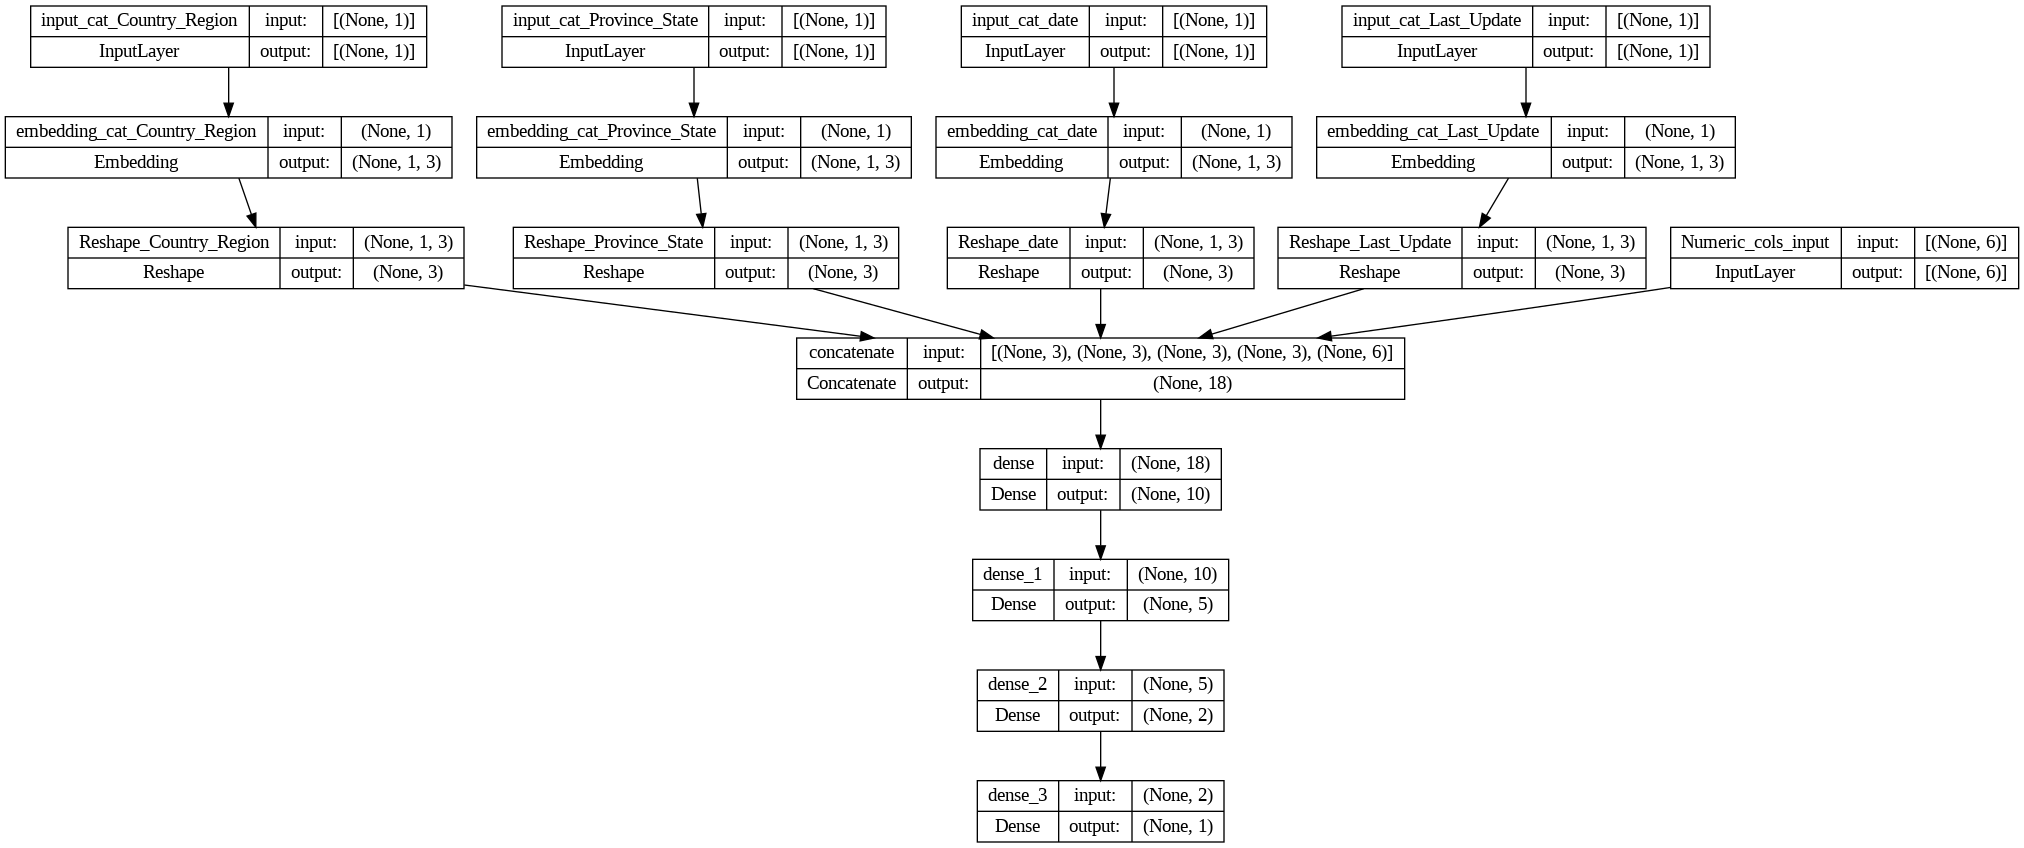

In [ ]:
# Print model structure
plot_model(nn, show_shapes=True, show_layer_names=True, to_file='Entity_embedding_model_keras.png')
Image(retina=True, filename='Entity_embedding_model_keras.png')

## Entreno RN

In [ ]:
# Compile model
nn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Set up early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=50,
                   restore_best_weights=True)

# Fit the model
history  =  nn.fit(input_list_train,
                   X_train['Deaths'],
                   validation_data=(input_list_test, X_test['Deaths']),
                   epochs=1000,#1000,
                   batch_size=64,#64,
                   verbose=1,
                   callbacks=[es])

Epoch 1/1000
32728/32728 [==============================] - 81s 2ms/step - loss: 121724.0625 - mae: 38.6924 - val_loss: 2903.0293 - val_mae: 15.5892
Epoch 2/1000
32728/32728 [==============================] - 79s 2ms/step - loss: 146134.2656 - mae: 39.5312 - val_loss: 118062.6953 - val_mae: 75.3391
Epoch 3/1000
32728/32728 [==============================] - 80s 2ms/step - loss: 67922.0625 - mae: 32.5448 - val_loss: 10697.7881 - val_mae: 26.5327
Epoch 4/1000
32728/32728 [==============================] - 79s 2ms/step - loss: 65030.5898 - mae: 30.0350 - val_loss: 9490.4307 - val_mae: 28.3914
Epoch 5/1000
32728/32728 [==============================] - 82s 2ms/step - loss: 45346.6406 - mae: 23.5385 - val_loss: 4536.1670 - val_mae: 21.3100
Epoch 6/1000
32728/32728 [==============================] - 80s 2ms/step - loss: 61852.9922 - mae: 27.8189 - val_loss: 3700.1470 - val_mae: 16.5185
Epoch 7/1000
32728/32728 [==============================] - 80s 2ms/step - loss: 48920.4141 - mae: 23.1447 

In [ ]:

# Save model
ruta_modelo =PATH_DATA_PROCESADA + "/modelo_prediccion/cat_embedding_keras.hdf5"
nn.save(ruta_modelo)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## muchas graficas para evaluar resultados

In [ ]:
y_test=X_test['Deaths']

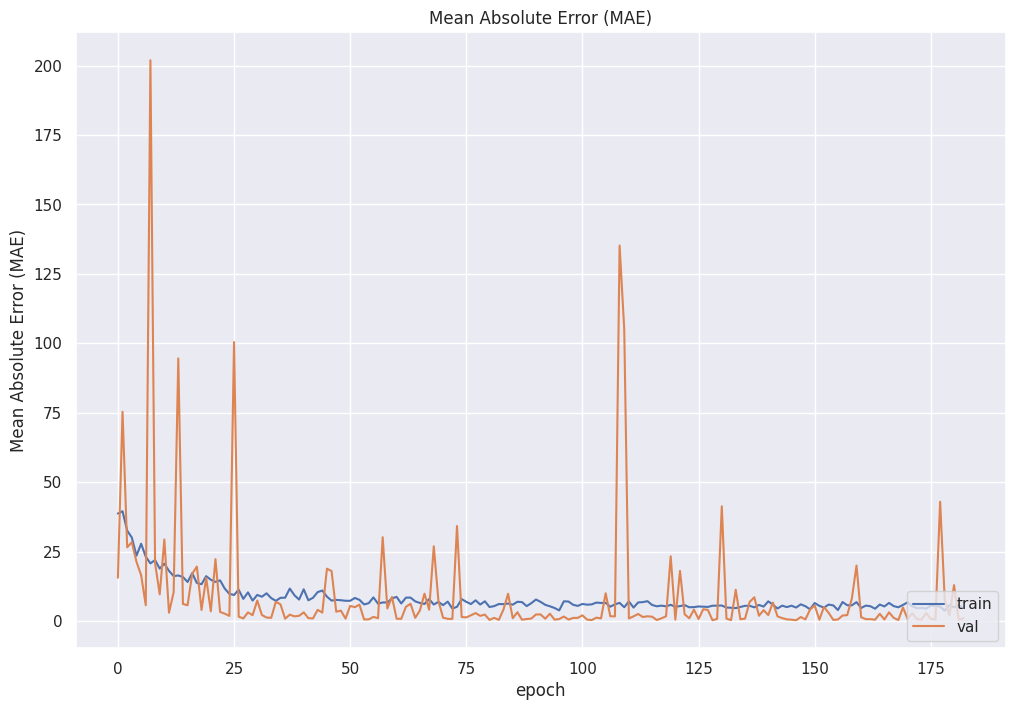

In [ ]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

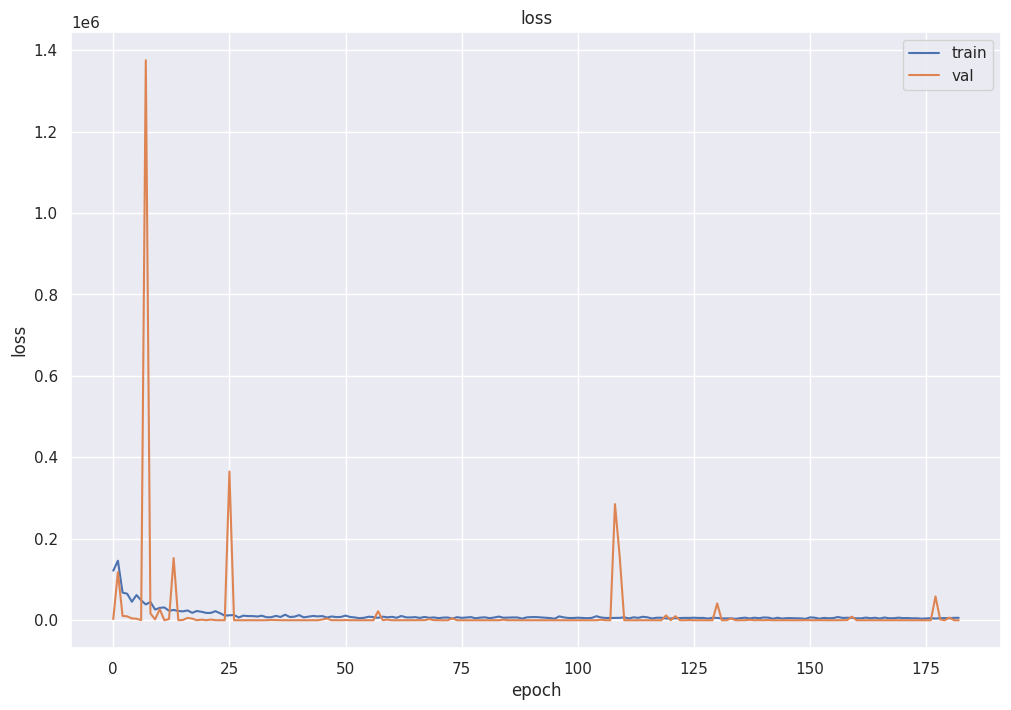

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

In [ ]:
# Make prediction
y_test_predict = nn.predict(input_list_test)

# Change the predictions from 2-d to 1-d
y_test_predict = y_test_predict.flatten()



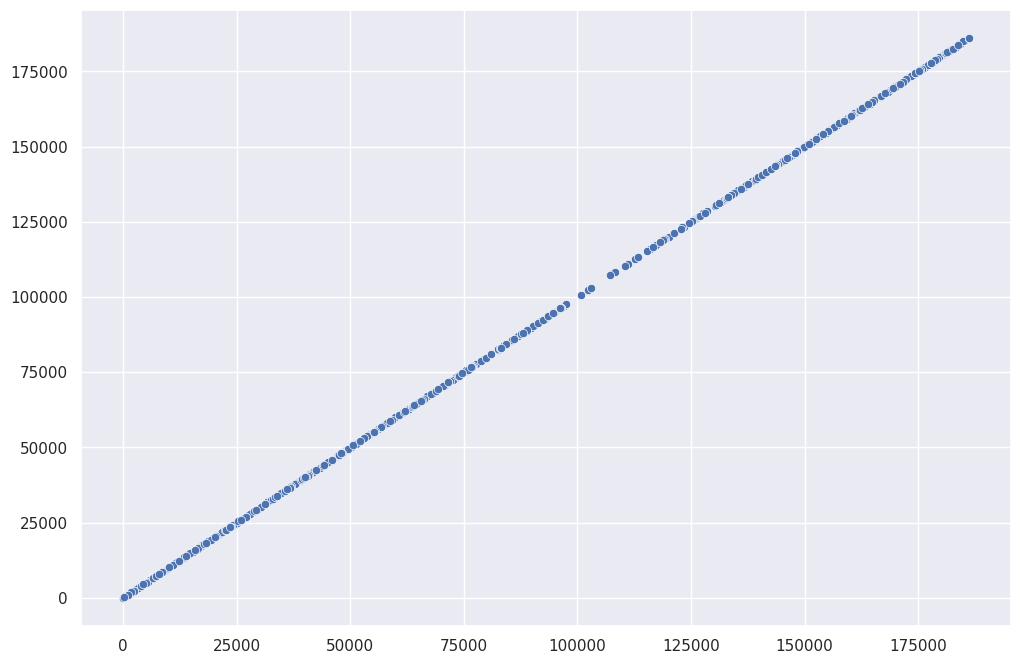

In [ ]:
# Visualization
ax = sns.scatterplot(x=y_test.to_numpy(), y=y_test_predict)

In [ ]:
# Calculate model error
model_error = y_test - y_test_predict

# Mean squared error
MSE = np.mean(model_error**2)
# Root mean squared error
RMSE = np.sqrt(MSE)
# Mean absolute error
MAE = np.mean(abs(model_error))
# R squared
R2 = 1- sum(model_error**2)/sum((y_test-np.mean(y_test))**2)
# Mean absolute percentage error
MAPE = np.mean(abs(model_error/y_test))

print(f'The MSE for the model is {MSE:.2f}')
print(f'The RMSE for the model is {RMSE:.2f}.')
print(f'The MAE for the model is {MAE:.2f}.')
print(f'The R-squared for the model is {R2:.2f}.')
print(f'The MAPE for the model is {MAPE:.2f}.')

The MSE for the model is 0.43
The RMSE for the model is 0.66.
The MAE for the model is 0.33.
The R-squared for the model is 1.00.
The MAPE for the model is inf.


In [ ]:
# Import library
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Mean squared error
MSE = mean_squared_error(y_test, y_test_predict)
# Root mean squared error
RMSE = np.sqrt(MSE)
# Mean absolute error
MAE = mean_absolute_error(y_test, y_test_predict)

R2 = r2_score(y_test, y_test_predict)
MAPE = mean_absolute_percentage_error(y_test, y_test_predict)

print(f'The MSE for the model is {MSE:.2f}')
print(f'The RMSE for the model is {RMSE:.2f}.')
print(f'The MAE for the model is {MAE:.2f}.')
print(f'The R-squared for the model is {R2:.2f}.')
print(f'The MAPE for the model is {MAPE:.2f}.')

The MSE for the model is 0.43
The RMSE for the model is 0.66.
The MAE for the model is 0.33.
The R-squared for the model is 1.00.
The MAPE for the model is 453546959536352.56.


## Extract weight of emmmbedings layers for column

In [ ]:
def getWeightsEmbbedings(columanas_categoricas):
  salida = []
  for col in columanas_categoricas:
    # Get weights from the embedding layer
    cat_emb_df = pd.DataFrame(nn.get_layer('embedding_cat_'+ col).get_weights()[0]).reset_index()

    # Add prefix to the embedding names
    cat_emb_df = cat_emb_df.add_prefix('cat_' + col + "_")
    # Take a look at the data
    salida.append({ 'columna': col,'cat_emb_df':cat_emb_df})
  return salida

cat_emb_df = getWeightsEmbbedings(columanas_categoricas)



In [ ]:
def getDfEncoderDictionaryAndEmmbedings():
  resultados = pandas.DataFrame()
  resultados = []
  for element in encoderCategorialVariables:
    encoder= element.get('cat_encoder')
    col = element.get('column')
    cat_emb= [x for x in cat_emb_df if x.get('columna') == col][0].get('cat_emb_df')

    # Put the categorical encoder dictionary into a dataframe
    cat_encoder_df = pd.DataFrame(encoder.items(), columns=[col, 'cat_'+ col + '_index'])

    # Merge data to append the category name
    cat_emb = pd.merge(cat_encoder_df, cat_emb, how = 'inner', on='cat_'+ col + '_index')
    resultados.append({'columna':col, 'cat_emb':cat_emb})
  return resultados

col_cat_emb= getDfEncoderDictionaryAndEmmbedings()

In [ ]:
# prompt: guardar y cargar col_cat_emb en la ruta path_embbedings

import pickle
path_embbedings=PATH_DATA_PROCESADA + '/embbedings_weights_' + '.pkl'

with open(path_embbedings, 'wb') as f:
    pickle.dump(col_cat_emb, f)



In [ ]:
# Load the data
with open(path_embbedings , 'rb') as f:
    col_cat_emb_open = pickle.load(f)

col_cat_emb_open

[{'columna': 'Country_Region',
  'cat_emb':     Country_Region  cat_Country_Region_index  cat_Country_Region_0  \
  0        Australia                         0              0.869002   
  1          Belgium                         1            105.608307   
  2           Brazil                         2              0.189256   
  3           Canada                         3              0.742776   
  4            Chile                         4              0.717863   
  5            China                         5              1.859425   
  6         Colombia                         6              0.640275   
  7          Denmark                         7              1.524079   
  8           France                         8              1.033990   
  9          Germany                         9              1.334591   
  10           India                        10              1.136548   
  11           Italy                        11              0.791492   
  12           Japan  

## prueba de carga del modelo

In [ ]:
# Load model
loaded_nn = load_model(ruta_modelo)